# Imports and dependencies

This cell loads the primary libraries and utilities used throughout the notebook.

- Data handling
    - `import pandas as pd` — tabular data manipulation, reading CSVs and creating DataFrames.
    - `import numpy as np` — numerical arrays and vectorized operations used for images and masks.

- Image I/O and filesystem
    - `from PIL import Image` — open/convert/resize TIFF and other image formats.
    - `import os, io, random` — file system operations, in-memory buffers, and random sampling.

- Data splitting
    - `from sklearn.model_selection import train_test_split` — create train/validation/test splits.

- Deep learning framework (TensorFlow / Keras)
    - `import tensorflow as tf` — core framework for model definition, training, and tf.data pipelines.
    - `from tensorflow.keras.models import Model` — functional API model class.
    - `from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Activation, Add, Multiply, ReLU` — building blocks for CNN / U-Net-style segmentation architectures.
    - `from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard` — training callbacks for early stopping, saving best models, and logging.
    - `from tensorflow.keras.losses import BinaryFocalCrossentropy` — focal loss used in custom composite loss.
    - `import tensorflow.keras.backend as K` — backend utilities (optional helpers for custom losses/metrics).

- Utilities
    - `import datetime` — create timestamped log directories for TensorBoard.
    - `import matplotlib.pyplot as plt` — visualization of images, masks, predictions, and training curves.

Notes
- These imports provide everything needed for dataset loading/augmentation, model construction (U-Net with attention), custom loss/metrics, training loops, and visualization found in subsequent cells.
- Ensure correct package versions (TensorFlow >= 2.x, scikit-learn, Pillow) and GPU setup if training on larger datasets.

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import os, io, random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Activation, Add, Multiply, ReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.losses import BinaryFocalCrossentropy
import tensorflow.keras.backend as K

import datetime
import matplotlib.pyplot as plt

## Configuration Parameters

Key hyperparameters and constants used throughout the notebook:

- **BATCH** = 8 — batch size for training, validation, and test datasets
- **RESIZE** = 128 — target image and mask dimensions (128×128 pixels)
- **EPS** = 1e-7 — small epsilon value for numerical stability in loss functions and clipping operations

These values are defined in the cell below and used in image preprocessing, data pipeline setup, and custom loss calculations.

In [2]:
BATCH = 8
RESIZE = 128
EPS = 1e-7

In [3]:
# def focal_tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, gamma=0.75, smooth=EPS):
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.clip_by_value(tf.cast(y_pred, tf.float32), smooth, 1 - smooth)

#     TP = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
#     FP = tf.reduce_sum((1 - y_true) * y_pred, axis=[1,2,3])
#     FN = tf.reduce_sum(y_true * (1 - y_pred), axis=[1,2,3])

#     tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
#     focal_tversky = tf.pow((1 - tversky), gamma)
#     return tf.reduce_mean(focal_tversky)


# def dice_coefficient(y_true, y_pred, smooth=1e-6):
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.clip_by_value(tf.cast(y_pred, tf.float32), smooth, 1 - smooth)
#     intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
#     denom = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
#     dice = (2. * intersection + smooth) / (denom + smooth)
#     return tf.reduce_mean(dice)


# def edge_loss(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.cast(y_pred, tf.float32)

#     edges_true = tf.image.sobel_edges(y_true)
#     edges_pred = tf.image.sobel_edges(y_pred)
    
#     diff = tf.abs(edges_true - edges_pred)
#     return tf.reduce_mean(diff) * 0.1  # 0.1 keeps it from dominating


# def total_segmentation_loss(y_true, y_pred,
#                             w_dice=0.7, w_tversky=0.25, w_edge=0.05):
#     loss_dice = 1 - dice_coefficient(y_true, y_pred)
#     loss_tversky = focal_tversky_loss(y_true, y_pred)
#     loss_edge = edge_loss(y_true, y_pred)

#     total_loss = (w_dice * loss_dice) + (w_tversky * loss_tversky) + (w_edge * loss_edge)
#     return total_loss


# def total_segmentation_loss_with_bce(y_true, y_pred, alpha=0.95, gamma=1.5):
#     bce = tf.keras.losses.BinaryFocalCrossentropy(alpha=alpha, gamma=gamma)
#     return total_segmentation_loss(y_true, y_pred) + 0.01 * bce(y_true, y_pred)



# class LossFn(tf.keras.losses.Loss):
#     def __init__(self, alpha=0.95, gamma=1.5):
#         super().__init__()
#         self.bce = tf.keras.losses.BinaryFocalCrossentropy(alpha=alpha, gamma=gamma)

#     def call(self, y_true, y_pred):
#         return total_segmentation_loss(y_true, y_pred) + 0.01 * self.bce(y_true, y_pred)

## Losses & metrics
- `dice_coefficient(y_true, y_pred)`: flattened Dice score computed with clipping for numerical stability; used as a metric and to derive Dice loss = 1 - Dice.
- `edge_loss(y_true, y_pred)`: computes Sobel edges for ground truth and prediction, returns mean absolute difference (encourages boundary alignment).
- `DiceFocalLoss` (tf.keras.losses.Loss):
    - Composite loss combining weighted Dice loss, Binary Focal loss (from `BinaryFocalCrossentropy`) and the `edge_loss`.
    - Weights: `w_dice`, `w_focal`, `w_edge` control contribution of each term.
    - Clips predictions to avoid log/zero issues before computing components.

In [4]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    y_pred_f = tf.clip_by_value(y_pred_f, smooth, 1)
    y_true_f = tf.clip_by_value(y_true_f, smooth, 1)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def edge_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    edges_true = tf.image.sobel_edges(y_true)
    edges_pred = tf.image.sobel_edges(y_pred)
    
    diff = tf.abs(edges_true - edges_pred)
    return tf.reduce_mean(diff)



class DiceFocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.95,
                        gamma=1.5,
                        w_dice=0.2,
                        w_edge=0.1,
                        w_focal = 0.002):
        super().__init__()
        self.focal = BinaryFocalCrossentropy(alpha=alpha, gamma=gamma)
        self.w_dice = w_dice
        self.w_edge = w_edge
        self.w_focal = w_focal

    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        dice_loss = 1 - dice_coefficient(y_true, y_pred)
        focal_loss = self.focal(y_true, y_pred)
        edge = edge_loss(y_true, y_pred)

        return (self.w_dice * dice_loss) + (self.w_focal * focal_loss) + (self.w_edge * edge)

In [5]:
# def load_tif_data(data_dir):
#     images, masks = [], []
#     for patient_dir in os.listdir(data_dir):
#         patient_path = os.path.join(data_dir, patient_dir)
#         if not os.path.isdir(patient_path):
#             continue
#         # Get all .tif files in the patient directory
#         tif_files = [f for f in os.listdir(patient_path) if f.endswith('.tif') and 'mask' not in f]
#         for img_file in tif_files:
#             img_path = os.path.join(patient_path, img_file)
#             images.append(img_path)
#             # Construct corresponding mask filename
#             mask_file = img_file.replace('.tif', '_mask.tif')
#             print(patient_path)
#             mask_path = os.path.join(patient_path, mask_file)
#             print(mask_path)
#             print()
#             masks.append(mask_path)
#             if not os.path.exists(mask_path):
#                 continue  # Skip if mask file doesn’t exist
    
#     return pd.DataFrame({'img': images, 'mask': masks})

In [6]:
# df = pd.read_csv('data_addrs_cpu.csv')
df = pd.read_csv('data_addrs.csv')

In [7]:
lbl = []

for each in df['mask'].tolist():
    im = Image.open(each)
    imarray = np.array(im)
    if np.sum(imarray) == 0:
        lbl.append(0)
    else:
        lbl.append(1)

df['label'] = pd.Series(lbl)
dff = df[df['label'] == 1].copy(deep=True)
dff.drop(['label'], axis=1, inplace=True)


In [8]:
dff.reset_index(drop=True).head()

,img,mask
0,/mnt/d/Github/Brain Tumor MRI Segmentation/dat...,/mnt/d/Github/Brain Tumor MRI Segmentation/dat...
1,/mnt/d/Github/Brain Tumor MRI Segmentation/dat...,/mnt/d/Github/Brain Tumor MRI Segmentation/dat...
2,/mnt/d/Github/Brain Tumor MRI Segmentation/dat...,/mnt/d/Github/Brain Tumor MRI Segmentation/dat...
3,/mnt/d/Github/Brain Tumor MRI Segmentation/dat...,/mnt/d/Github/Brain Tumor MRI Segmentation/dat...
4,/mnt/d/Github/Brain Tumor MRI Segmentation/dat...,/mnt/d/Github/Brain Tumor MRI Segmentation/dat...


In [9]:
# df['label'].value_counts()

In [10]:
# idx = 58
# masks = dff['mask'].tolist()
# images = dff['img'].tolist()
# mask = masks[idx]
# image = images[idx]
# maskg = Image.open(mask)
# mask = np.array(maskg)
# # plt.imshow(maskg)
# imageg = Image.open(image)
# image = np.array(imageg)
# # plt.imshow(imageg)

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(maskg, cmap='gray')
# ax[0].set_title("Mask")

# ax[1].imshow(imageg, cmap='gray')
# ax[1].set_title("Image")

# plt.show()

## Augmentation & preprocessing
- `preprocess(image, mask)`: applies `random_crop_with_zoomout` which randomly (probability p) performs a mask‑aware crop+zoomout; otherwise resizes to target.
- `random_crop_with_zoomout`:
    - Chooses between augmentation and identity using `tf.cond` with a random uniform draw (keeps augmentation inside the TF graph).
- `mask_aware_crop(image, mask, target_size)`:
    - Finds nonzero mask coordinates and computes a bounding box around the mask.
    - Adds a "zoomout" margin (based on distance to image borders) to include context.
    - Crops image & mask and resizes to `target_size` (bilinear for image, nearest for mask).

Notes: RESIZE and BATCH are global config values used for sizing and batching.

In [11]:
def preprocess(image, mask):
    return random_crop_with_zoomout(image, mask, target_size=(RESIZE, RESIZE), p=0.3)


def random_crop_with_zoomout(image, mask, target_size=(RESIZE, RESIZE), p=0.5):
    """
    Apply crop+zoomout augmentation randomly with probability p.
    """
    # Generate random number
    do_augment = tf.random.uniform([], 0, 1.0) < p

    def augmented():
        return mask_aware_crop(image, mask, target_size)

    def identity():
        # Just resize without augmentation
        image_resized = tf.image.resize(image, target_size, method='bilinear')
        mask_resized = tf.image.resize(mask, target_size, method='nearest')
        return image_resized, mask_resized

    return tf.cond(do_augment, augmented, identity)


def mask_aware_crop(image, mask, target_size=(RESIZE, RESIZE)):
    # mask = tf.cast(mask, tf.int32)
    row, col = tf.shape(mask)[0], tf.shape(mask)[1]

    # Find nonzero indices (True positions)
    non_zero = tf.where(mask > 0)

    # Get bounding box coordinates
    r_min = tf.reduce_min(non_zero[:, 1])
    r_max = tf.reduce_max(non_zero[:, 1])
    c_min = tf.reduce_min(non_zero[:, 0])
    c_max = tf.reduce_max(non_zero[:, 0])

    # Compute distances to borders
    rmindist = tf.cast(r_min, tf.int32)
    cmindist = tf.cast(c_min, tf.int32)
    rmaxdist = tf.cast(col, tf.int32) - tf.cast(r_max, tf.int32)
    cmaxdist = tf.cast(row, tf.int32) - tf.cast(c_max, tf.int32)

    zoomout = tf.minimum(tf.minimum(rmindist, rmaxdist),
                        tf.minimum(cmindist, cmaxdist))

    zoomout_factor = tf.where(zoomout > 50, 0.3, 0.8)
    zoomout = tf.cast(tf.cast(zoomout, tf.float32) * zoomout_factor, tf.int32)

    # Expanded box coordinates (clamped to image size)
    rmin = tf.cast(tf.maximum(tf.cast(r_min, tf.int64) - tf.cast(zoomout, tf.int64), 0), tf.int32)
    cmin = tf.cast(tf.maximum(tf.cast(c_min, tf.int64) - tf.cast(zoomout, tf.int64), 0), tf.int32)
    rmax = tf.cast(tf.minimum(tf.cast(r_max, tf.int64) + tf.cast(zoomout, tf.int64), tf.cast(col, tf.int64)), tf.int32)
    cmax = tf.cast(tf.minimum(tf.cast(c_max, tf.int64) + tf.cast(zoomout, tf.int64), tf.cast(row, tf.int64)), tf.int32)

    # Crop image and mask
    cropped_mask = mask[cmin:cmax, rmin:rmax]
    cropped_img = image[cmin:cmax, rmin:rmax]

    resized_img = tf.image.resize(cropped_img, target_size, method='bilinear')
    # cropped_mask = tf.expand_dims(cropped_mask, axis=-1)
    resized_mask = tf.image.resize(cropped_mask, target_size, method='nearest')
    # resized_mask = tf.squeeze(resized_mask, axis=-1)
    
    return resized_img, resized_mask

In [12]:
x_tr, x_val = train_test_split(dff, test_size=0.3, random_state=42)
x_val, x_ts = train_test_split(x_val, test_size=0.5, random_state=42)

print(f"Train: {len(x_tr)}, Val: {len(x_val)}, Test: {len(x_ts)}")

Train: 961, Val: 206, Test: 206


## Data loading
- `_load_tif_image(path, ch)`:
    - Runs in NumPy/Pillow via `tf.numpy_function`.
    - Opens TIFF, converts to RGB or grayscale based on `ch`, resizes to RESIZE×RESIZE, normalizes to [0,1], and ensures channel dimension exists.
- `load_image_and_mask(image_path, mask_path)`:
    - Wraps `_load_tif_image` in `tf.numpy_function` and sets static shapes so TF knows tensor shapes for downstream ops.

Rationale: `tf.numpy_function` is used to leverage Pillow for TIFF handling while keeping the pipeline in tf.data.

In [13]:
def _load_tif_image(path, ch):
    img = Image.open(path.decode())
    
    if int(ch) == 3:
        img = img.convert('RGB')
    else:
        img = img.convert('L')
    
    img = img.resize((RESIZE, RESIZE))
    img = np.array(img).astype(np.float32) / 255.0

    # If grayscale (2D), expand to [H, W, 1]
    if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)
    return img


def load_image_and_mask(image_path, mask_path):
    # Load image
    image = tf.numpy_function(_load_tif_image, [image_path, 3], tf.float32)
    image.set_shape([RESIZE, RESIZE, 3])  # or [RESIZE, RESIZE, 1]

    # Load mask (assume single channel)
    mask = tf.numpy_function(_load_tif_image, [mask_path, 1], tf.float32)
    mask.set_shape([RESIZE, RESIZE, 1])

    return image, mask

## tf.data pipelines
- Creates datasets from pandas columns: `trds`, `vlds`, `tsds`.
- Training pipeline:
    - shuffle -> map(load) -> map(preprocess) -> cache -> batch -> prefetch
- Validation and test pipelines:
    - map(load) -> cache -> batch -> prefetch
- Uses `tf.data.AUTOTUNE` for parallelism and prefetching for performance.

In [14]:
trds = tf.data.Dataset.from_tensor_slices((x_tr['img'], x_tr['mask']))
vlds = tf.data.Dataset.from_tensor_slices((x_val['img'], x_val['mask']))
tsds = tf.data.Dataset.from_tensor_slices((x_ts['img'], x_ts['mask']))


trds = (trds
	.shuffle(1024)
	.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
	.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
	.cache()
	.batch(BATCH)
	.prefetch(tf.data.AUTOTUNE)
)

vlds = (vlds
	.shuffle(1024)
	.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
	.cache()
	.batch(BATCH)
	.prefetch(tf.data.AUTOTUNE)
)

tsds = (tsds
	.shuffle(1024)
	.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
	.cache()
	.batch(BATCH)
	.prefetch(tf.data.AUTOTUNE)
)

I0000 00:00:1763320588.722284   46527 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1766 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [15]:
# for a, b in trds.take(1):
#     print(a)
#     print()
#     print(b)

In [16]:
# for img, mask in trds.take(3):
#     plt.subplot(1,2,1)
#     plt.imshow(img[0])
#     plt.subplot(1,2,2)
#     plt.imshow(mask[0,...,0], cmap='gray')
#     plt.show()

## Model architecture
- `attention_gate(x, g, inter_channels)`:
    - 1×1 convolutions on encoder skip `x` and gating signal `g`, adds them, applies ReLU, a 1×1 conv + sigmoid to produce an attention map, multiplies attention map with `x` to modulate skip features.
- `TumorSegNet_withAttention(input_shape)`:
    - U‑Net style encoder → bottleneck → decoder.
    - At each decoder level, an attention gate refines the corresponding encoder skip before concatenation.
    - Final output: single-channel sigmoid segmentation mask.

In [17]:
def attention_gate(x, g, inter_channels):
    """
    Attention gate: x -> encoder feature (skip), g -> decoder gating signal.
    Returns: x * attention_map (same shape as x).
    """
    # 1x1 conv to reduce channels
    theta_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(g)

    add_xg = Add()([theta_x, phi_g])
    act = ReLU()(add_xg)

    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(act)
    psi = Activation('sigmoid')(psi)   # attention coefficients in [0,1]

    # broadcast multiply: attention map (H,W,1) * x (H,W,C)
    attn_out = Multiply()([x, psi])
    return attn_out


def TumorSegNet_withAttention(input_shape=(256, 256, 3)):
    inputs = Input(input_shape, name='Input_Layer')

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same', name='Conv1_1')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same', name='Conv1_2')(c1)
    p1 = MaxPooling2D((2, 2), name='MaxPool1')(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same', name='Conv2_1')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same', name='Conv2_2')(c2)
    p2 = MaxPooling2D((2, 2), name='MaxPool2')(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same', name='Conv3_1')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same', name='Conv3_2')(c3)
    p3 = MaxPooling2D((2, 2), name='MaxPool3')(c3)

    # Bottleneck
    c4 = Conv2D(512, 3, activation='relu', padding='same', name='Bottleneck_Conv1')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same', name='Bottleneck_Conv2')(c4)
    c4 = Dropout(0.5, name='Bottleneck_Dropout')(c4)

    # Decoder - level 3 (connects to c3)
    u3 = UpSampling2D((2, 2), name='UpSample3')(c4)
    # attention gate for c3 using gating signal u3
    att3 = attention_gate(c3, u3, inter_channels=128)  # inter_channels ~ half of skip channels
    u3 = concatenate([u3, att3], name='Concat3')
    c5 = Conv2D(256, 3, activation='relu', padding='same', name='Conv5_1')(u3)
    c5 = Conv2D(256, 3, activation='relu', padding='same', name='Conv5_2')(c5)

    # Decoder - level 2 (connects to c2)
    u2 = UpSampling2D((2, 2), name='UpSample2')(c5)
    att2 = attention_gate(c2, u2, inter_channels=64)
    u2 = concatenate([u2, att2], name='Concat2')
    c6 = Conv2D(128, 3, activation='relu', padding='same', name='Conv6_1')(u2)
    c6 = Conv2D(128, 3, activation='relu', padding='same', name='Conv6_2')(c6)

    # Decoder - level 1 (connects to c1)
    u1 = UpSampling2D((2, 2), name='UpSample1')(c6)
    att1 = attention_gate(c1, u1, inter_channels=32)
    u1 = concatenate([u1, att1], name='Concat1')
    c7 = Conv2D(64, 3, activation='relu', padding='same', name='Conv7_1')(u1)
    c7 = Conv2D(64, 3, activation='relu', padding='same', name='Conv7_2')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid', name='Output_Layer')(c7)

    return Model(inputs, outputs, name='TumorSegNet_Attention')


## Training & callbacks
- Loads pretrained weights from `'TumorSegNet1.keras'`, transfers weights to the attention model, then compiles with:
    - optimizer: Adam(1e-4)
    - loss: `DiceFocalLoss()`
    - metrics: `dice_coefficient`, `edge_loss`
- Callbacks:
    - `ModelCheckpoint` to save best model by `val_dice_coefficient`.
    - `TensorBoard` logging (including images and histograms).
    - `PredictionLogger` (commented out in callbacks list): custom callback that predicts for a few validation images every epoch and logs a matplotlib figure as an image to TensorBoard using `plot_to_image`.

`plot_to_image(figure)` converts a Matplotlib figure to a PNG tensor accepted by TensorBoard.

In [ ]:
# Instantiate and compile model
old = tf.keras.models.load_model('TumorSegNet1.keras', compile=False)
model = TumorSegNet_withAttention(input_shape=(RESIZE, RESIZE, 3))
model.set_weights(old.get_weights())
del old
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=DiceFocalLoss(),
            metrics=[dice_coefficient, edge_loss])

# TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=0
)

# Custom callback to log sample predictions to TensorBoard
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self, val_images, val_masks):
        super(PredictionLogger, self).__init__()
        self.val_images = val_images[:5]  # Log first 5 validation images
        self.val_masks = val_masks[:5]

    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(self.val_images)
        preds = (preds > 0.5).astype(np.uint8)
        
        # Create figure with images, true masks, and predictions
        fig = plt.figure(figsize=(15, 5 * len(self.val_images)))
        for i in range(len(self.val_images)):
            plt.subplot(len(self.val_images), 3, i * 3 + 1)
            plt.imshow(self.val_images[i].squeeze(), cmap='gray')
            plt.title('MRI Image')
            plt.axis('off')
            plt.subplot(len(self.val_images), 3, i * 3 + 2)
            plt.imshow(self.val_masks[i].squeeze(), cmap='gray')
            plt.title('True Mask')
            plt.axis('off')
            plt.subplot(len(self.val_images), 3, i * 3 + 3)
            plt.imshow(preds[i].squeeze(), cmap='gray')
            plt.title(f'Predicted Mask (Epoch {epoch + 1})')
            plt.axis('off')
        
        # Log figure to TensorBoard
        writer = tf.summary.create_file_writer(log_dir)
        with writer.as_default():
            tf.summary.image("Validation Predictions", plot_to_image(fig), step=epoch)
        plt.close(fig)

# Convert matplotlib figure to TensorBoard image format
def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

# Other callbacks
callbacks = [
    # EarlyStopping(patience=5, restore_best_weights=True, monitor='val_dice_coefficient', mode='max'),
    ModelCheckpoint('TumorSegNet_attbest.keras', save_best_only=True, monitor='val_dice_coefficient', mode='max'),
    tensorboard_callback,
    # PredictionLogger(x_val['img'], x_val['mask'])
]

# Train the model
history = model.fit(
    trds,
    validation_data=vlds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


2025-11-16 20:49:27.820748: I external/local_xla/xla/service/service.cc:163] XLA service 0x726bc4015410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-16 20:49:27.820786: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-11-16 20:49:28.091990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-16 20:49:29.281586: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500
2025-11-16 20:49:30.942034: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-16 20:49:31.26533

121/121 ━━━━━━━━━━━━━━━━━━━━ 89s 502ms/step - dice_coefficient: 0.8794 - edge_loss: 0.0377 - loss: 0.0280 - val_dice_coefficient: 0.8778 - val_edge_loss: 0.0284 - val_loss: 0.0274
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - dice_coefficient: 0.8857 - edge_loss: 0.0369 - loss: 0.0267 - val_dice_coefficient: 0.8562 - val_edge_loss: 0.0312 - val_loss: 0.0319
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - dice_coefficient: 0.8792 - edge_loss: 0.0378 - loss: 0.0281 - val_dice_coefficient: 0.8820 - val_edge_loss: 0.0292 - val_loss: 0.0266
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - dice_coefficient: 0.8941 - edge_loss: 0.0358 - loss: 0.0249 - val_dice_coefficient: 0.8856 - val_edge_loss: 0.0281 - val_loss: 0.0257
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - dice_coefficient: 0.9000 - edge_loss: 0.0347 - loss: 0.0236 - val_dice_coefficient: 0.8826 - val_edge_loss: 0.0289 - val_loss: 0.0263
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step -

## Saving, history and visualization
- After training, model saved with `model.save('TumorSegNet.keras')`.
- Training history keys are used to extract metrics (dice, val_dice) and losses (edge_loss, val_edge_loss) for plotting.
- `visualize_predictions(model, dataset, num_samples, threshold)`:
    - Samples a small subset from a tf.data.Dataset, flattens into individual samples, selects random examples, runs model.predict on each, binarizes predictions with a threshold and plots image / ground truth / predicted mask triples for quick inspection.

---

## Practical notes
- Shapes must be consistent: images → (RESIZE, RESIZE, 3), masks → (RESIZE, RESIZE, 1).
- Using `tf.numpy_function` breaks graph portability (e.g., for TPU) but is pragmatic for Pillow-based TIFF handling.
- Random augmentation uses TF ops so it runs inside the input pipeline and benefits from parallel mapping/prefetching.

In [25]:
model.save('TumorSegNet.keras')

In [19]:
dice = history.history['dice_coefficient']
val_dice = history.history['val_dice_coefficient']
loss = history.history['edge_loss']
val_loss = history.history['val_edge_loss']

In [33]:
dice

[0.14021575450897217,
 0.35740262269973755,
 0.5369921922683716,
 0.6167147159576416,
 0.6465065479278564,
 0.6622185707092285,
 0.6809433698654175,
 0.692557692527771,
 0.6990198493003845,
 0.7090258598327637,
 0.721513569355011,
 0.7275596261024475,
 0.7325968146324158,
 0.7519823312759399,
 0.7610089182853699,
 0.7592492699623108,
 0.7656627893447876,
 0.7745746970176697,
 0.7750077247619629,
 0.7887858152389526,
 0.798158586025238,
 0.7951757311820984,
 0.7974458932876587,
 0.8059138655662537,
 0.8061954379081726,
 0.8046543598175049,
 0.8142346739768982,
 0.8131267428398132,
 0.8171806931495667,
 0.8224052786827087]

/tmp/ipykernel_24601/1236131419.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()
/tmp/ipykernel_24601/1236131419.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


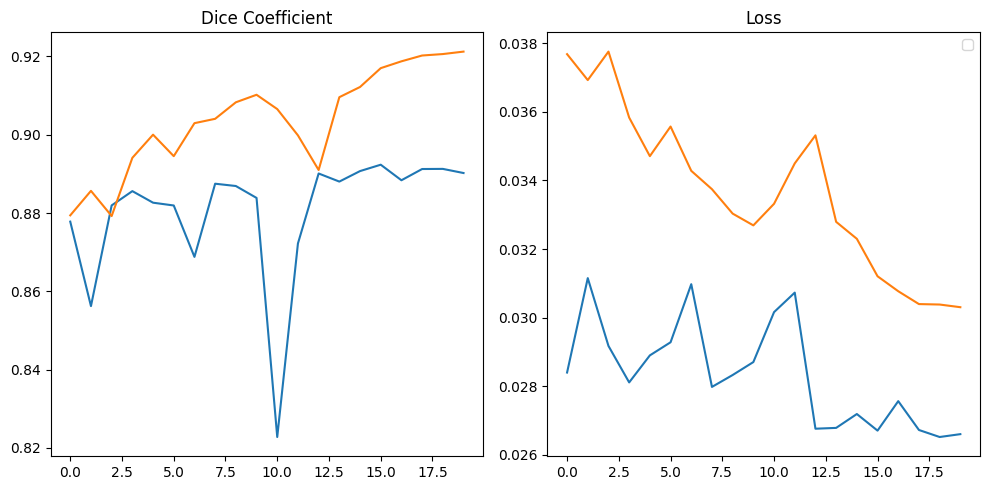

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(val_dice)
axes[0].plot(dice)
axes[0].set_title('Dice Coefficient')
axes[1].legend()

axes[1].plot(val_loss)
axes[1].plot(loss)
axes[1].set_title('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

In [17]:
import random


def visualize_predictions(model, dataset, num_samples=5, threshold=0.5):
    """
    Visualizes model predictions for random samples in a tf.data.Dataset
    
    model: trained segmentation model
    dataset: tf.data.Dataset yielding (image, mask)
    num_samples: number of random samples to show
    threshold: threshold to binarize predicted mask
    """

    # Convert a small subset to numpy for random access
    data = list(dataset.take(10))  # take first 10 batches (safe)
    
    # Flatten dataset samples
    samples = []
    for img_batch, mask_batch in data:
        for i in range(len(img_batch)):
            samples.append((img_batch[i], mask_batch[i]))

    # Choose random samples
    chosen = random.sample(samples, num_samples)

    plt.figure(figsize=(15, num_samples * 3))

    for idx, (image, mask) in enumerate(chosen):

        # Prepare batch of size 1 for model
        pred = model.predict(image[None, ...])[0]

        # Binarize predicted mask
        pred_mask = (pred > threshold).astype(np.float32)

        # plot
        plt.subplot(num_samples, 3, idx*3 + 1)
        plt.imshow(tf.squeeze(image), cmap='gray')
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, idx*3 + 2)
        plt.imshow(tf.squeeze(mask), cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, idx*3 + 3)
        plt.imshow(tf.squeeze(pred_mask), cmap='gray')
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


2025-11-16 22:50:24.048712: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-16 22:50:24.058723: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-16 22:50:24.675767: I external/local_xla/xla/service/service.cc:163] XLA service 0x78043001ed20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-16 22:50:24.675799: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-11-16 22:50:24.761429: I tensorflow/compiler/mlir/tensorflow/

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


I0000 00:00:1763320829.180524   46797 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


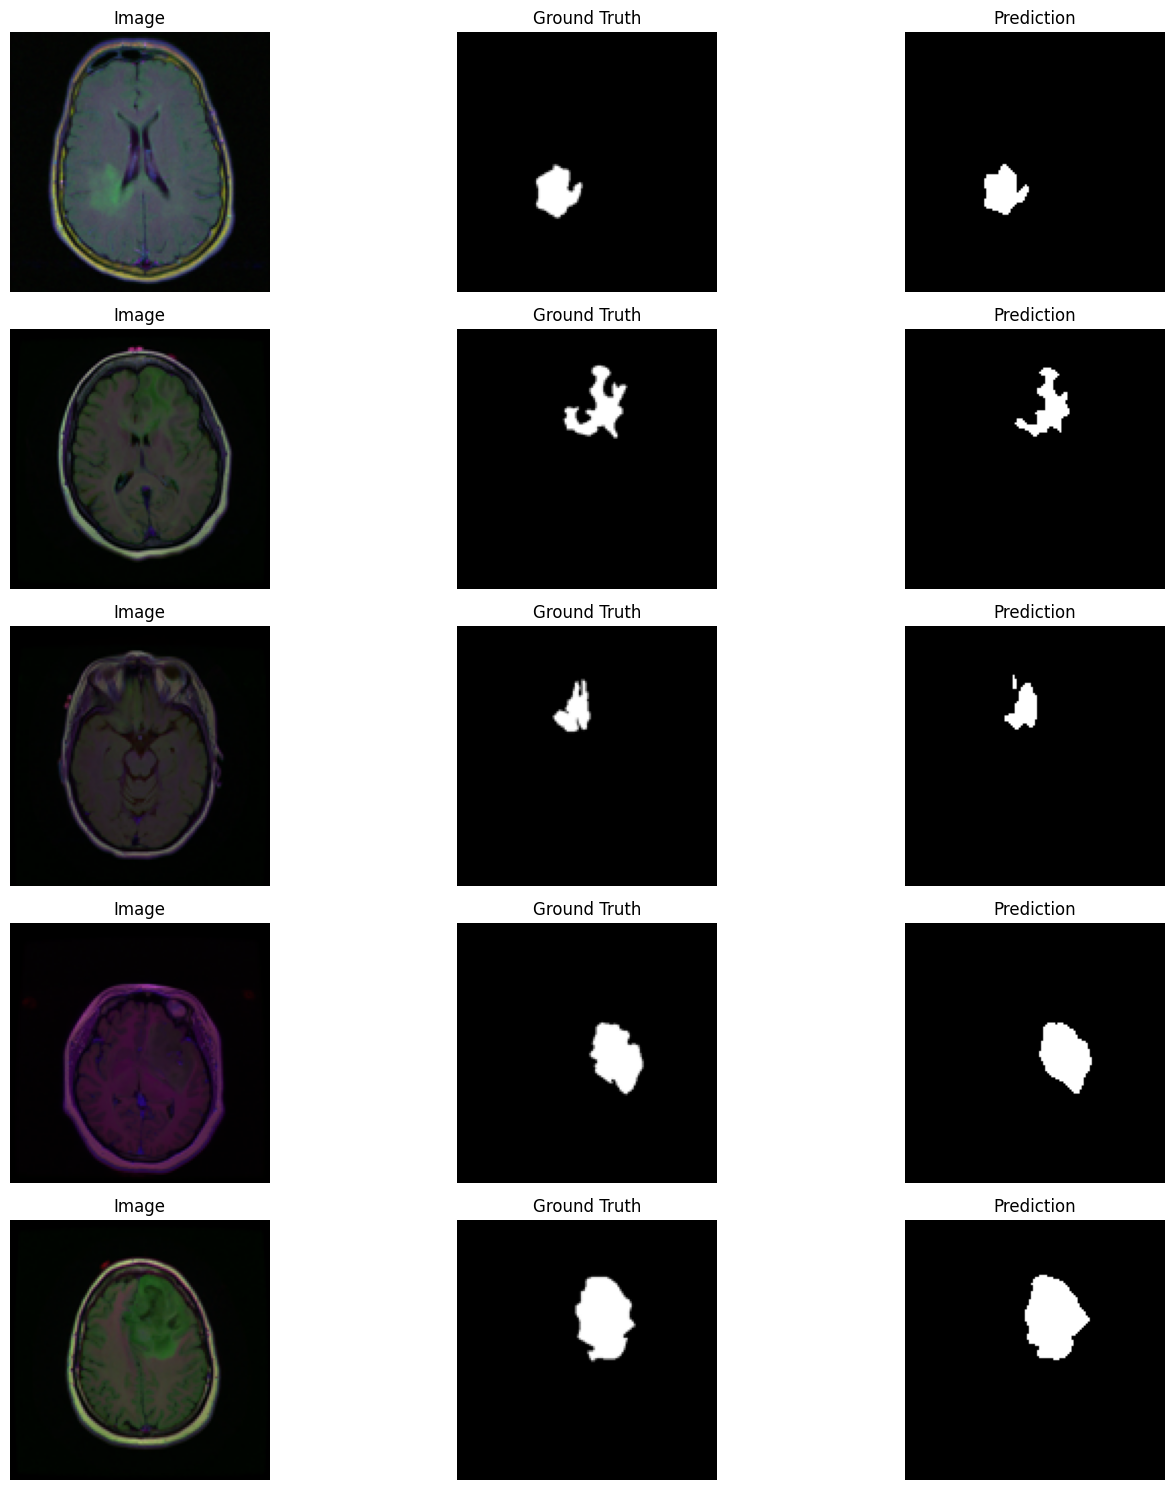

In [19]:
model = tf.keras.models.load_model('TumorSegNet1.keras', compile=False)
visualize_predictions(model, vlds)